In [1]:
pip install tensorflow matplotlib numpy


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


In [4]:
# Load MNIST dataset
(X_train, _), (_, _) = keras.datasets.mnist.load_data()

# Normalize and reshape
X_train = (X_train.astype("float32") - 127.5) / 127.5  # Scale to [-1, 1]
X_train = np.expand_dims(X_train, axis=-1)  # Reshape for the model

BUFFER_SIZE = 60000
BATCH_SIZE = 128

# Create dataset
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [5]:
def build_generator():
    model = keras.Sequential([
        layers.Dense(128, activation="relu", input_shape=(100,)),
        layers.Dense(7 * 7 * 128, activation="relu"),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu"),
        layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="same", activation="tanh")
    ])
    return model

generator = build_generator()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
def build_discriminator():
    model = keras.Sequential([
        layers.Conv2D(64, kernel_size=3, strides=2, padding="same", input_shape=(28, 28, 1)),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")  # Output: probability real/fake
    ])
    return model

discriminator = build_discriminator()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [7]:
cross_entropy = keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0002)


In [8]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs=10):
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
        print(f"Epoch {epoch+1}/{epochs}, Gen Loss: {gen_loss.numpy()}, Disc Loss: {disc_loss.numpy()}")

train(dataset, epochs=10)


Epoch 1/10, Gen Loss: 0.6022610664367676, Disc Loss: 1.464545726776123
Epoch 2/10, Gen Loss: 0.7255029678344727, Disc Loss: 1.5183360576629639
Epoch 3/10, Gen Loss: 3.962718963623047, Disc Loss: 0.027255121618509293
Epoch 4/10, Gen Loss: 5.015856742858887, Disc Loss: 0.010965563356876373
Epoch 5/10, Gen Loss: 2.33418869972229, Disc Loss: 0.24447807669639587
Epoch 6/10, Gen Loss: 4.597216606140137, Disc Loss: 0.038421012461185455
Epoch 7/10, Gen Loss: 5.207118988037109, Disc Loss: 0.01967325061559677
Epoch 8/10, Gen Loss: 5.691692352294922, Disc Loss: 0.007722274865955114
Epoch 9/10, Gen Loss: 5.977884292602539, Disc Loss: 0.0032794708386063576
Epoch 10/10, Gen Loss: 6.647119998931885, Disc Loss: 0.001802370185032487


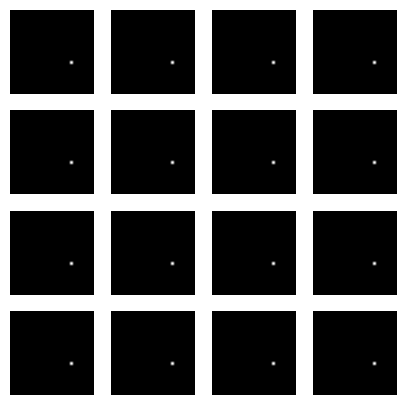

In [9]:
def generate_images(generator, num_images=16):
    noise = tf.random.normal([num_images, 100])
    generated_images = generator(noise, training=False)

    fig, axes = plt.subplots(4, 4, figsize=(5, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i, :, :, 0], cmap="gray")
        ax.axis("off")
    plt.show()

generate_images(generator)
